I submitted this version a little bit late since I don't think the last version was perfect, and I indeed managed to make some optimizations over the codes.(The last version of mine is enough for a good mark but I just want to be a little bit more perfect.)
    1. Did some data preprocessing to clean the text.
    2. Used another model found on kaggle which “ was initialized from the base Wikipedia + BooksCorpus BERT model and was fine-tuned on the Stanford Sentiment Treebank (SST-2), a dataset for sentiment analysis.” The model runs pretty well, and yet hit the 90 percent wall as well.
    3. Optimized the model applying process so that it would take less memory( my PC kept crashing for that reason)
    4. fixed some bug.
    
Things to notice:
    My tensorflow was not the best version due to the limitation of my hardware. So something might not be optimized the most.
    There are irony in terms of some complains which would be one of a obvious reason for error.

In [1]:
import numpy as np
import tensorflow as tf
tf.config.list_physical_devices('GPU') # list available GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# text cleaning
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'd+','',text)
    text = re.sub(r'[^\w\s]','',text)
    tokens = nltk.word_tokenize(text)
    return tokens

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

def perform_lemmatization(tokens):
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

def clean_text(text):
    tokens = preprocess_text(text)
    filtered_tokens = remove_stopwords(tokens)
    lemmatized_tokens = perform_lemmatization(filtered_tokens)
    clean_text = ''.join(lemmatized_tokens)
    return clean_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\84648\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\84648\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\84648\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\84648\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from tensorflow import keras
from tensorflow.keras.utils import text_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, TextVectorization, Bidirectional, GlobalMaxPooling1D, GRU

import matplotlib.pyplot as plt
def plotEpoch( history, metric='acc'):
    epochs = range(len(history['loss']))
    if metric=='acc':
        plt.plot(epochs, history['accuracy'], 'k', label='Training acc')
        val = history['val_accuracy']
        plt.plot(epochs, val, 'b', label='Validation acc')
        plt.axvline(x=val.index(max(val)), color='r')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()
    elif metric=='loss':
        plt.plot(epochs, history['loss'], 'k', label='Training loss')
        val = history['val_loss']
        plt.plot(epochs, val, 'b', label='Validation loss')
        plt.axvline(x=val.index(min(val)), color='r')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()

In [5]:
# Load the data from the uploaded files
pos_file_path = 'C:/Users/84648/Desktop/DeepLearningFinal/pos.txt'
neg_file_path = 'C:/Users/84648/Desktop/DeepLearningFinal/neg.txt'

# Reading the content of positive and negative result files
with open(pos_file_path, 'r', encoding='utf-8') as pos_file:
    pos_samples = pos_file.readlines()

with open(neg_file_path, 'r', encoding='utf-8') as neg_file:
    neg_samples = neg_file.readlines()

# Show a sample of the data (first 5 samples from each)
pos_samples[:5], neg_samples[:5], len(pos_samples), len(neg_samples)


(['@united oh I switched to AA abt a year ago after hitting MM status. but do have a flight soon on UA so was curious.\n',
  "@AlaskaAir yes! Can't wait to check out your local booze selection on board! Cheers!\n",
  "Got to love @JetBlue! Can't wait to book my next trip @greggweiss\n",
  'Have no fear @JetBlue is here April 30th!! #cleveland @clevelanddotcom @CleveNOW #Boston #FtLauderdale @Chestertucky @TedDimond @bnorris99\n',
  "Can't wait to meet #Skeeter and his #NutFree cookies on @JetBlue tomorrow morning\n"],
 ['Have spent over 4 hours trying to purchase tickets on a @united MileagePlus Explorer card. On hold again. Thinking @SouthwestAir next time.\n',
  '.@HeathrowAirport waiting on @united 97 from Houston #planespotting #travel http://t.co/VVcmIv4I88\n',
  'As a 1K frequent flyer on @united I can honestly say I have never been more frustrated with this airline. Becoming worse by the day\n',
  "For an industry that's in dire need of a business model shakeup. it's sad to see 

In [6]:
from sklearn.model_selection import train_test_split


# Preprocess the data: Basic cleaning and removing newline characters
pos_clean = []
for i in pos_samples:
    pos_clean.append(clean_text(i))

neg_clean = []
for i in neg_samples:
    neg_clean.append(clean_text(i))

# Label the data: 1 for positive, 0 for negative
pos_labels = [1] * len(pos_clean)
neg_labels = [0] * len(neg_clean)

# Combine data and labels
samples = pos_clean + neg_clean
labels = pos_labels + neg_labels

# Convert lists to numpy arrays for compatibility with TensorFlow
samples_array = np.array(samples)
labels_array = np.array(labels)

# Shuffle and split into training and validation sets
samples_train, samples_val, labels_train, labels_val = train_test_split(samples_array, labels_array, test_size=0.2, random_state=42)

# Show the sizes of the splits
samples_train.shape, samples_val.shape, labels_train.shape, labels_val.shape


((12468,), (3118,), (12468,), (3118,))

In [7]:
# Create TensorFlow Dataset objects for both training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((samples_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((samples_val, labels_val))

# Batch the datasets
train_dataset = train_dataset.batch(12)
val_dataset = val_dataset.batch(12)

In [11]:
labels_train[0:5]

array([0, 1, 0, 1, 0])

In [3]:
import tensorflow_hub as hub
import tensorflow_text
from official.nlp import optimization

C:\Users\84648\anaconda3\envs\myenv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\84648\anaconda3\envs\myenv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If yo

In [4]:
# @title
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base': 'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small': 'https://tfhub.dev/google/electra_small/2',
    'electra_base': 'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed': 'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books': 'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base': 'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'SST-2' :'https://www.kaggle.com/models/google/experts-bert/frameworks/TensorFlow2/variations/wiki-books-sst2/versions/2'}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base': 'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', 
    'SST-2' : 'https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3'
}
#bert_multi_cased_L-12_H-768_A-12 can't run on my PC
#'bert_en_cased_L-12_H-768_A-12 can't either
#'bert_en_cased_L-12_H-768_A-12' can't eithe

#'small_bert/bert_en_uncased_L-4_H-512_A-8' can
# L-6 can
# L-8 can
#L-12 can
#L-10_H-768_A-12  nope
#small_bert/bert_en_uncased_L-12_H-512_A-8 can! results are 90(good)
#'albert_en_base' can!@!@! also 90

In [5]:
bert_model_name = 'SST-2'
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
bert_model = hub.KerasLayer(tfhub_handle_encoder)
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

ValueError: Trying to load a model of incompatible/unknown type. 'C:\Users\84648\AppData\Local\Temp\tfhub_modules\4e777089f1941e0df686e25ac7b1967fd777e370' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.

In [ ]:
def build_bert_classifier():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [27]:
bert_classifier = build_bert_classifier()
#pip install pydot
## install graphviz
#tf.keras.utils.plot_model(bert_classifier)

In [28]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [29]:
#epochs = 10
#steps_per_epoch = len(train_dataset)
#num_train_steps = steps_per_epoch * epochs
#num_warmup_steps = int(0.1*num_train_steps)
#optimizer = optimization.create_optimizer(init_lr=3e-5, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')
#loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:

bert_classifier.compile( optimizer=optimizer, loss=loss,  metrics=["accuracy"]  )

Epoch 1/6
1039/1039 [==============================] - 189s 172ms/step - loss: 0.5887 - accuracy: 0.6740 - val_loss: 0.4725 - val_accuracy: 0.7707
Epoch 2/6
1039/1039 [==============================] - 177s 170ms/step - loss: 0.4510 - accuracy: 0.7905 - val_loss: 0.4839 - val_accuracy: 0.8130
Epoch 3/6
1039/1039 [==============================] - 177s 171ms/step - loss: 0.3651 - accuracy: 0.8488 - val_loss: 0.5810 - val_accuracy: 0.8127
Epoch 4/6
1039/1039 [==============================] - 178s 172ms/step - loss: 0.3110 - accuracy: 0.8801 - val_loss: 0.7045 - val_accuracy: 0.8072
Epoch 5/6
1039/1039 [==============================] - 177s 171ms/step - loss: 0.2628 - accuracy: 0.9106 - val_loss: 0.7564 - val_accuracy: 0.8368
Epoch 6/6
1039/1039 [==============================] - 179s 172ms/step - loss: 0.2163 - accuracy: 0.9310 - val_loss: 0.8369 - val_accuracy: 0.8377


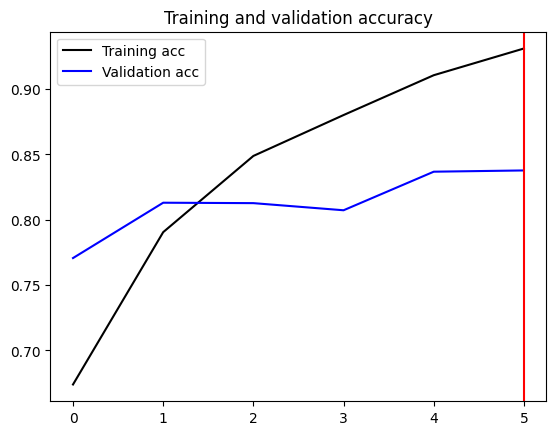

<Figure size 640x480 with 0 Axes>

In [31]:
history = bert_classifier.fit( train_dataset, validation_data=val_dataset, epochs=6)
plotEpoch( history.history )

In [ ]:
print(f"Test acc: {bert_classifier.evaluate(val_dataset)[1]:.3f}")

In [ ]:
bert_classifier.save('C:/Users/84648/Desktop/DeepLearningFinal/small_bert/SST-2', include_optimizer=False)
model = tf.saved_model.load('C:/Users/84648/Desktop/DeepLearningFinal/small_bert/SST-2')

In [ ]:
stop

In [ ]:
import pandas as pd
df = pd.read_csv('C:/Users/84648/Desktop/DeepLearningFinal/customertweets.csv',header = None)

In [ ]:

for i in range (1,50000):
    df.loc[i,2]=float(tf.sigmoid( model(tf.constant([df.loc[i,1]]))))
    print (i) 
df = df.loc[1:50000]

df = pd.to_csv('C:/Users/84648/Desktop/DeepLearningFinal/customertweets_1.csv',header = None)

In [ ]:
df.to_csv('C:/Users/84648/Desktop/DeepLearningFinal/customertweets_1.csv',header = None)

In [ ]:
df = pd.read_csv('C:/Users/84648/Desktop/DeepLearningFinal/customertweets.csv',header = None)
for i in range (50000,100000):
    df.loc[i,2]=float(tf.sigmoid( model(tf.constant([df.loc[i,1]]))))
    print (i) 
df = df.loc[50000:100000]
df.to_csv('C:/Users/84648/Desktop/DeepLearningFinal/customertweets_2.csv',header = None)

In [ ]:
df = pd.read_csv('C:/Users/84648/Desktop/DeepLearningFinal/customertweets.csv',header = None)
for i in range (100000,len(df)):
    df.loc[i,2]=float(tf.sigmoid( model(tf.constant([df.loc[i,1]]))))
    print (i) 
df = df.loc[100000:]
df.to_csv('C:/Users/84648/Desktop/DeepLearningFinal/customertweets_3.csv',header = None)

In [ ]:
df1 = pd.read_csv('C:/Users/84648/Desktop/DeepLearningFinal/customertweets_1.csv',header = None)
df2 = pd.read_csv('C:/Users/84648/Desktop/DeepLearningFinal/customertweets_2.csv',header = None)
df3 = pd.read_csv('C:/Users/84648/Desktop/DeepLearningFinal/customertweets_3.csv',header = None)
frames = [df1, df2, df3]

result = pd.concat(frames)
result

In [ ]:
result.to_csv('C:/Users/84648/Desktop/DeepLearningFinal/SST-2_result.csv', index=False)
sum(result[3] >.9)/len(result)

In [ ]:
result = pd.read_csv('C:/Users/84648/Desktop/DeepLearningFinal/SST-2_result.csv',header = None)

In [ ]:
result = result[result[3]>0.5][[0,2]]
result.to_csv('C:/Users/84648/Desktop/DeepLearningFinal/SST-2_extract.csv', index=False)

In [ ]:
bert_classifier.summary()

In [ ]:
https://www.tensorflow.org/hub/api_docs/python/hub/load

In [ ]:
https://www.kaggle.com/models/google/experts-bert/frameworks/tensorFlow2/variations/wiki-books-sst2

In [ ]:
https://www.tensorflow.org/hub?hl=zh-cn

In [ ]:
https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [ ]:
https://medium.com/@pawan329/text-data-preprocessing-made-easy-steps-to-clean-text-data-using-python-81a138a0e0e3